# Solution for the ground state 1D transverse field Ising model using VQE
### by Nicolas Parra and Carlos Garavitos

In [4]:
!pip install numpy qiskit qutip typeguard typing matplotlib

  Using cached typing-3.7.4.3.tar.gz (78 kB)
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26308 sha256=a0b72136a10cd4e9e8d294a4dab4dd2ac1ddb09017f0a519b71010bbb9b98141
  Stored in directory: /Users/nicolasparra/Library/Caches/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


### We want solve the 1D ising model with a tranversal field using a Variational quantum eigensolver(VQE)
The hamiltonian is:
<br/><br/>
\\( H = - J\sum_{i}^{N-1} \sigma_{i}^{z}\sigma_{i+1}^{z}-h\sum_{i}^{N} \sigma_{i}^{x}  \\)
<br/><br/>

where \\( \sigma_x and \sigma_z \\) are the pauli matrices

#### We create a class that do a exact solution a VQE solution
First import all packages necessaries

In [1]:
import numpy as np
from qutip import *
from typeguard import typechecked
from typing import List
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA, SLSQP
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.operators import Z2Symmetries
from qiskit import BasicAer, IBMQ
from qiskit.aqua import QuantumInstance
import time
from matplotlib import pyplot as plt

In [2]:
class Ising_Hamiltonian():
    '''
    Class to build a Hamiltonian 1D ising and solve this with exact solution and VQE
    '''
    @typechecked
    def __init__(self,N:int):
        '''
        Parameters
        ----------
        N: int
            size of ising chain
        '''
        self._size = N
        self._hamiltonian = None
        self._eigenvalues = None
        self._eigenvectors = None
        self._minenergy_exact = None
        self._minenergy_vqe = None
        self._ev_energy = None
        self._counts = None

    @property
    def ev_energy(self):
        return self._ev_energy 
    
    @property
    def counts(self):
        return self._counts 

    @property
    def size(self):
        return self._size

    @property
    def hamiltonian(self):
        return self._hamiltonian

    @property
    def eigenvalues(self):
        return self._eigenvalues
    
    @property
    def eigenvectors(self):
        return self._eigenvectors

    @property
    def minenergy_exact(self):
        return self._minenergy_exact

    @property
    def minenergy_vqe(self):
        return self._minenergy_vqe
    
    @typechecked
    def hamiltonian_fit(self,J:float,h:float):
        '''
        Function that bulid the hamiltonian of ising with tranversal field 
        https://stanford.edu/~jeffjar/statmech/lec4.html

        Parameters
        ----------
        J: float
            interacition between the spins
        h: float
            Tranversal field apply to the spins
        
        Note
        ----
        Save the Hamiltonian H in `self._hamiltonian`
        '''
        si = qeye(2)
        sz = sigmaz() #Pauli matrix z
        sx = sigmax() #Pauli matrix x

        sz_list = []
        sx_list = []

        for n in range(self._size):
            op_list = []
            for m in range(self._size):
                op_list.append(si)

            op_list[n] = sz
            sz_list.append(tensor(op_list))
            op_list[n] = sx
            sx_list.append(tensor(op_list))

        # construct the hamiltonian
        H = 0

        # energy splitting terms
        for n in range(self._size):
            H += - h * sx_list[n]

        # interaction terms
        for n in range(self._size-1):
            H += - J * sz_list[n] * sz_list[n+1]

        self._hamiltonian = H
        print(H)

    def solve_exact(self):
        '''
        Function to solve exactly the problem

        Note
        ----
        The results are save in `self._eingenvalues` and `self._eigenvectors`
        '''
        self._eigenvalues, self._eigenvectors = self.hamiltonian.eigenstates()
        self._minenergy_exact = min(self.eigenvalues)
    
    @typechecked
    def solve_vqe(self,maxiter : int = 400 ,qubit_mapping: str='jordan_wigner',type_run: str='simulator',save_convergence: bool = False,entanglement='linear'):
        '''
        Function to solve the system with a VQE 

        Parameters
        ----------
        maxiter: int
            Number of optimeze iterations 
        qubit_mapping: str 
            Type of mapping to quantum computer ("jordan_wigner", "parity", "bravyi_kitaev", "bksf"), to the ising problem we must use "jordan_wigner"
        type_run: str
            Type of run the vqe, in a simulator `'simulator'` or a real device `'qc-real'`,
            default 'simulator'
        save_convergence: boolean
            If true, save the evolution of the energy in each iteration 
        entanglement:str
            Type of entanglement in variational form `'linear'` or `'full'` 
        '''
        # How ising chain is a fermionic operator we crate the hamiltonian in qiskit with `FermionicOperator`
        fop = FermionicOperator(h1 = np.array(self.hamiltonian))
        
        #The optimezer
        optimizer = COBYLA(maxiter=maxiter, tol=0.0000001)
        
        #Mapping the hamiltionian to a quantum object of qiskit
        qubitOp = fop.mapping(map_type=qubit_mapping, threshold=0.0001)
        qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, self.size)
        print('Number of qubits using',(qubitOp.num_qubits))
        
        #These ese the class of variational form, the circuit change if we use the linear entanglement or full entanglement
        #We don´t use other possible variational form because is necessary do a wrapper a variationaform class of qiskit (Take long time)
        var_form = EfficientSU2(qubitOp.num_qubits, entanglement=entanglement)
        
        #If we want save the iteration data, this change the way to create the VQE
        if save_convergence:
            counts = []
            values = []
            def store_intermediate_result(eval_count, parameters, mean, std):
                counts.append(eval_count)
                values.append(mean)
            #Create the VQE with a Hamiltonian, a varaitional forma and a optimizer
            vqe = VQE(qubitOp, var_form, optimizer=optimizer, callback=store_intermediate_result,quantum_instance=QuantumInstance(backend=BasicAer.get_backend("qasm_simulator")))
            self._ev_energy = values
            self._counts = counts
        else:
            #Create the VQE with a Hamiltonian, a varaitional forma and a optimizer
            vqe = VQE(qubitOp,var_form, optimizer=optimizer)
    
        #If we want run in a simulator or real device
        if type_run == 'simulator':
            if save_convergence:
                self._minenergy_vqe = np.real(vqe.compute_minimum_eigenvalue(operator=qubitOp)['eigenvalue'])
            else:
                backend = BasicAer.get_backend("qasm_simulator")
                self._minenergy_vqe = np.real(vqe.run(backend)['eigenvalue'])

        elif type_run == 'qc-real':
            IBMQ.load_account()
            provider = IBMQ.get_provider(hub='ibm-q')
            backend = provider.get_backend("ibmq_16_melbourne")
            device_backend = backend.configuration()
            coupling_map = device_backend.coupling_map
            quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4192, 
                                   coupling_map=coupling_map)
            ret = vqe.run(quantum_instance)
            self._minenergy_vqe = np.real(ret['eigenvalue'])
        
        else:
            raise TypeError('Wrong type in type_run')

## Simple case, solve a ising 1D with n=3

In [14]:
start_time = time.time()
ising = Ising_Hamiltonian(3) #Initiallize the ising
ising.hamiltonian_fit(J=0.5,h=0.06) #Give the parameters of hamiltonian

ising.solve_exact() #Solve through exact diagonalization 
ising.solve_vqe(maxiter = 350,
                qubit_mapping="jordan_wigner",
                entanglement='linear') #Solve through variational quantum eigensolver with a varatioanl form EfficientSU2 with linear entanglement

exact = ising.minenergy_exact
vqe_value = ising.minenergy_vqe
print("This is the exact energy of the ground state {0}".format(exact))
print("This is the vqe energy of the ground state {0} with linear entanglement".format(vqe_value))
print("Porcentual difference {0}".format((vqe_value-exact)/exact*100))
print("--The run take {0} seconds".format((time.time() - start_time)))

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-1.   -0.06 -0.06  0.   -0.06  0.    0.    0.  ]
 [-0.06  0.    0.   -0.06  0.   -0.06  0.    0.  ]
 [-0.06  0.    1.   -0.06  0.    0.   -0.06  0.  ]
 [ 0.   -0.06 -0.06  0.    0.    0.    0.   -0.06]
 [-0.06  0.    0.    0.    0.   -0.06 -0.06  0.  ]
 [ 0.   -0.06  0.    0.   -0.06  1.    0.   -0.06]
 [ 0.    0.   -0.06  0.   -0.06  0.    0.   -0.06]
 [ 0.    0.    0.   -0.06  0.   -0.06 -0.06 -1.  ]]
Number of qubits using 6
This is the exact energy of the ground state -1.0098609872514657
This is the vqe energy of the ground state -0.8821289062499996 with linear entanglement
Porcentual difference -12.648481584491536
--The run take 235.9795219898224 seconds


## See the evolution of convergence to n=3 and change the type of variational form (EfficientSU2 with linear entanglement and EfficientSU2 with full entanglement)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-1.   -0.06 -0.06  0.   -0.06  0.    0.    0.  ]
 [-0.06  0.    0.   -0.06  0.   -0.06  0.    0.  ]
 [-0.06  0.    1.   -0.06  0.    0.   -0.06  0.  ]
 [ 0.   -0.06 -0.06  0.    0.    0.    0.   -0.06]
 [-0.06  0.    0.    0.    0.   -0.06 -0.06  0.  ]
 [ 0.   -0.06  0.    0.   -0.06  1.    0.   -0.06]
 [ 0.    0.   -0.06  0.   -0.06  0.    0.   -0.06]
 [ 0.    0.    0.   -0.06  0.   -0.06 -0.06 -1.  ]]
Number of qubits using 6
---- To 3 spins ---- 
This is the exact energy of the ground state -1.0098609872514657
This is the vqe energy of the ground state -1.0104882812499996 with linear entanglement
Porcentual difference 0.062116866227419965 
Number of qubits using 6
This is the vqe energy of the ground state -0.7833398437499998 with full entanglement
Porcentual difference -22.43092330143256


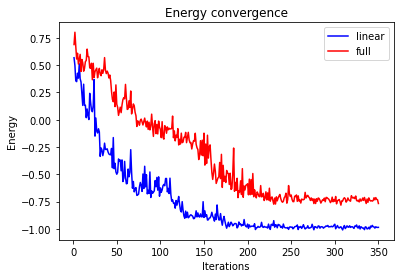

--- Seconds 847.5627672672272


<Figure size 432x288 with 0 Axes>

In [18]:
num_spins = [3]
for spin in num_spins:
    start_time = time.time()

    ising = Ising_Hamiltonian(spin) #Initiallize the ising
    ising.hamiltonian_fit(J=0.5,h=0.06) #Give the parameters of hamiltonian

    ising.solve_exact() #Solve through exact diagonalization 
    ising.solve_vqe(maxiter = 350,qubit_mapping="jordan_wigner",entanglement='linear',save_convergence = True) #Solve through variational quantum eigensolver

    exact = ising.minenergy_exact
    vqe_value = ising.minenergy_vqe
    plt.plot(ising.counts,ising.ev_energy,label='linear',color='blue')
    
    print("---- To {0} spins ---- ".format(spin))
    print("This is the exact energy of the ground state {0}".format(exact))
    print("This is the vqe energy of the ground state {0} with linear entanglement".format(vqe_value))
    print("Porcentual difference {0} ".format((vqe_value-exact)/exact*100))

    ising.solve_vqe(maxiter = 350,qubit_mapping="jordan_wigner",entanglement='full',save_convergence = True) #Solve through variational quantum eigensolver
    vqe_value = ising.minenergy_vqe
    plt.plot(ising.counts,ising.ev_energy,label='full',color='red')

    print("This is the vqe energy of the ground state {0} with full entanglement".format(vqe_value))
    print("Porcentual difference {0}".format((vqe_value-exact)/exact*100))
    

    plt.title('Energy convergence')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()
    plt.clf()
    print("--- Seconds {0}".format((time.time() - start_time)))

### We evaluate the solution in fuction of parameter \\( J/h \\) 

It take some hours !!!!!!

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-0.1  -0.06 -0.06  0.   -0.06  0.    0.    0.  ]
 [-0.06  0.    0.   -0.06  0.   -0.06  0.    0.  ]
 [-0.06  0.    0.1  -0.06  0.    0.   -0.06  0.  ]
 [ 0.   -0.06 -0.06  0.    0.    0.    0.   -0.06]
 [-0.06  0.    0.    0.    0.   -0.06 -0.06  0.  ]
 [ 0.   -0.06  0.    0.   -0.06  0.1   0.   -0.06]
 [ 0.    0.   -0.06  0.   -0.06  0.    0.   -0.06]
 [ 0.    0.    0.   -0.06  0.   -0.06 -0.06 -0.1 ]]
Number of qubits using 6
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-0.2  -0.06 -0.06  0.   -0.06  0.    0.    0.  ]
 [-0.06  0.    0.   -0.06  0.   -0.06  0.    0.  ]
 [-0.06  0.    0.2  -0.06  0.    0.   -0.06  0.  ]
 [ 0.   -0.06 -0.06  0.    0.    0.    0.   -0.06]
 [-0.06  0.    0.    0.    0.   -0.06 -0.06  0.  ]
 [ 0.   -0.06  0.    0.   -0.06  0.2   0.   -0.06]
 [ 0.    0.   -0.06  0.   -0.06  0.    0.   -0.06]
 [ 0.

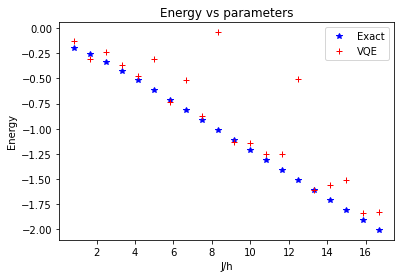

<Figure size 432x288 with 0 Axes>

In [19]:
Js = np.linspace(0.05,1,20)
ising = Ising_Hamiltonian(3)
ex_energy = []
vqe_energy = []
for j in Js:
    start_time = time.time()
     #Initiallize the ising
    ising.hamiltonian_fit(J=j,h=0.06) #Give the parameters of hamiltonian
    ising.solve_exact() #Solve through exact diagonalization 
    ising.solve_vqe(maxiter = 350,qubit_mapping="jordan_wigner",entanglement='linear',save_convergence = False) #Solve through variational quantum eigensolver

    exact = ising.minenergy_exact
    vqe_value = ising.minenergy_vqe
    ex_energy.append(exact)
    vqe_energy.append(vqe_value)

plt.plot(Js/0.06,ex_energy,'*',color='blue',label='Exact')
plt.plot(Js/0.06,vqe_energy,'+',color='red',label='VQE')
plt.title('Energy vs parameters')
plt.xlabel('J/h')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.clf()

### For the case of n=2

In [4]:
Js = np.linspace(0.05,1,20)
ising = Ising_Hamiltonian(2)
ex_energy = []
vqe_energy = []
for j in Js:
    start_time = time.time()
     #Initiallize the ising
    ising.hamiltonian_fit(J=j,h=0.06) #Give the parameters of hamiltonian
    ising.solve_exact() #Solve through exact diagonalization 
    ising.solve_vqe(maxiter = 350,qubit_mapping="jordan_wigner",entanglement='linear',save_convergence = False) #Solve through variational quantum eigensolver

    exact = ising.minenergy_exact
    vqe_value = ising.minenergy_vqe
    ex_energy.append(exact)
    vqe_energy.append(vqe_value)

plt.plot(Js/0.06,ex_energy,'*',color='blue',label='Exact')
plt.plot(Js/0.06,vqe_energy,'+',color='red',label='VQE')
plt.title('Energy vs parameters')
plt.xlabel('J/h')
plt.ylabel('Energy')
plt.legend()
plt.show()
plt.clf()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-0.05 -0.06 -0.06  0.  ]
 [-0.06  0.05  0.   -0.06]
 [-0.06  0.    0.05 -0.06]
 [ 0.   -0.06 -0.06 -0.05]]
Number of qubits using 2
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-0.1  -0.06 -0.06  0.  ]
 [-0.06  0.1   0.   -0.06]
 [-0.06  0.    0.1  -0.06]
 [ 0.   -0.06 -0.06 -0.1 ]]
Number of qubits using 2
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-0.15 -0.06 -0.06  0.  ]
 [-0.06  0.15  0.   -0.06]
 [-0.06  0.    0.15 -0.06]
 [ 0.   -0.06 -0.06 -0.15]]
Number of qubits using 2
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-0.2  -0.06 -0.06  0.  ]
 [-0.06  0.2   0.   -0.06]
 [-0.06  0.    0.2  -0.06]
 [ 0.   -0.06 -0.06 -0.2 ]]
Number of qubits using 2
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = T

<Figure size 432x288 with 0 Axes>